In [1]:
from google.colab import drive
drive.mount('/content/drive')


#Importing data from kaggle settings
! pip install kaggle 
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download uciml/sms-spam-collection-dataset
! unzip sms-spam-collection-dataset.zip

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 211k/211k [00:00<00:00, 399kB/s]
100% 211k/211k [00:00<00:00, 399kB/s]
Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                


In [53]:
!pip3 install catboost
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno #Heatmap
from sklearn.preprocessing import LabelEncoder
import pickle

import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

#TF



import tensorflow as tf
import keras
from keras.models import Sequential


from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout


from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

import pickle
pd.set_option('display.max_rows', None)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
df = pd.read_csv('/content/spam.csv', encoding="latin-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [31]:
print(df.shape)
print('==========')
print(df.info())
print('==========')
print(df.describe())

(5572, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None
          v1                      v2  \
count   5572                    5572   
unique     2                    5169   
top      ham  Sorry, I'll call later   
freq    4825                      30   

                                               Unnamed: 2  \
count                                                  50   
unique                                                 43   
top      bt not his girlfrnd... G o o d n i g h t . . .@"   
freq                                                    3   

                   Unnamed: 3 Unnamed: 4  
count  

In [32]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)
df.rename(columns={'v1':'target','v2':'text'},inplace=True) #drop columns
df = df.drop_duplicates(keep='first') #drop duplicates
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target']) #1 hot
df.head()

<ipython-input-32-1eb4d78e23d3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = encoder.fit_transform(df['target']) #1 hot


,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [33]:
print(f'{df.isnull().sum()}\nNum duplicates: {df.duplicated().sum()}')
df.shape

target    0
text      0
dtype: int64
Num duplicates: 0


(5169, 2)

0    4516
1     653
Name: target, dtype: int64


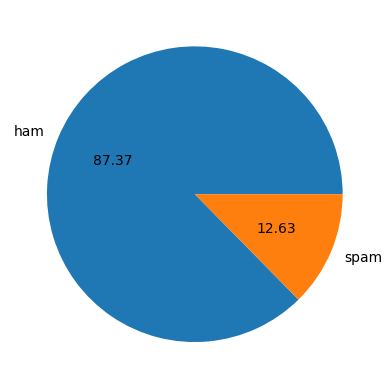

In [34]:
print(df['target'].value_counts())
plt.pie(df['target'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

In [35]:
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [36]:
# ham
df[df['target'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [37]:
#spam
df[df['target'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


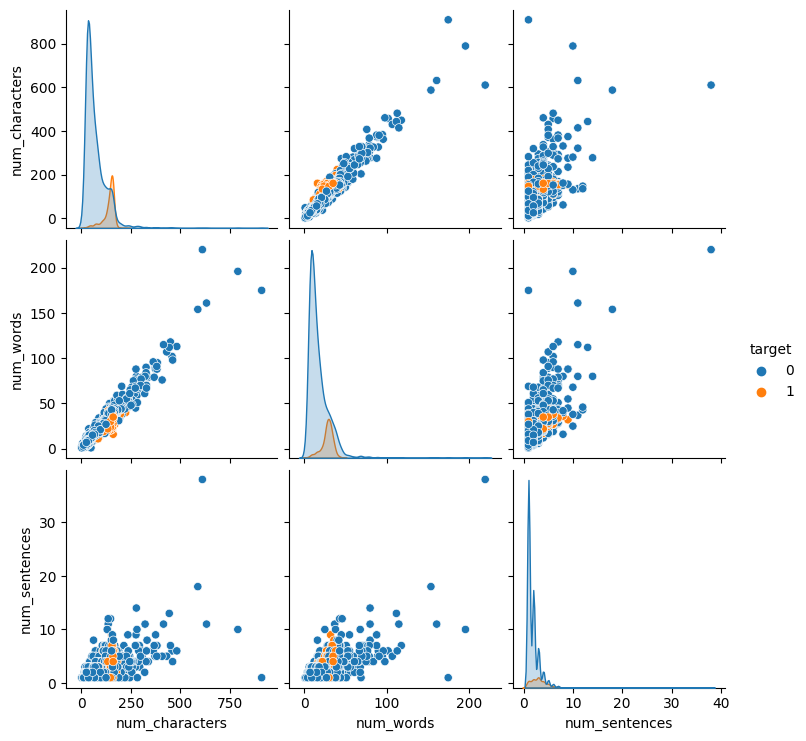

In [38]:
sns.pairplot(df,hue='target')

<ipython-input-39-35e09545cfa7>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=df.corr(),


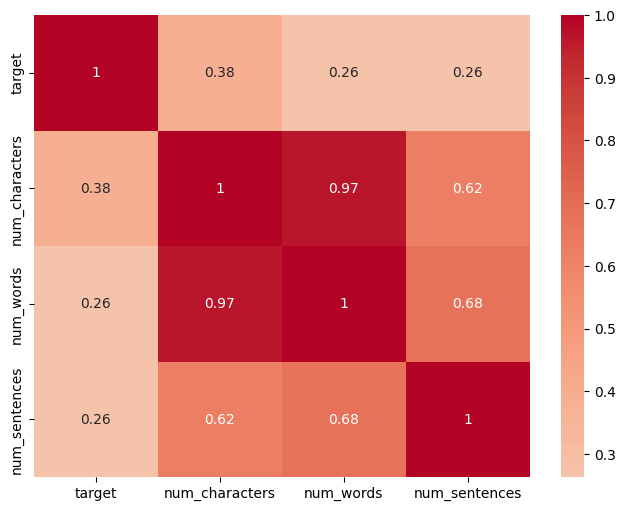

In [39]:
sns.heatmap(data=df.corr(),
            annot=True,
            cmap="coolwarm",
            center=0,
            ax=plt.subplots(figsize=(8,6))[1]);

# Data preprocessing
* Lower case
* Tokenization
* Removing special characters
* Removing stop words and punctuation
* Stemming

In [40]:
def transform_text(text):
    # Convert the text to lowercase and tokenize it
    tokens = nltk.word_tokenize(text.lower())
    
    # Remove non-alphanumeric tokens (%^# )
    tokens = [t for t in tokens if t.isalnum()]
    
    # Remove stopwords and punctuation (I, how, u, are, is)
    stopwords_set = set(stopwords.words('english'))
    punctuation_set = set(string.punctuation)
    tokens = [t for t in tokens if t not in stopwords_set and t not in punctuation_set]
    
    # Stemming the remaining tokens using PorterStemmer (loving=love)
    ps = PorterStemmer()
    tokens = [ps.stem(t) for t in tokens]
    
    # Join the tokens back into a string and return it
    return " ".join(tokens)

In [41]:
print(f"{df['text'][10]}\n{transform_text(df['text'][10])}")

I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.
gon na home soon want talk stuff anymor tonight k cri enough today


In [42]:
df['transformed_text'] = df['text'].apply(transform_text)
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


# EDA

In [43]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

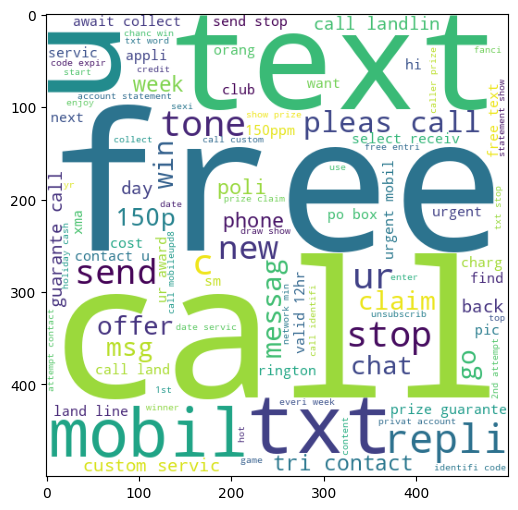

In [44]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

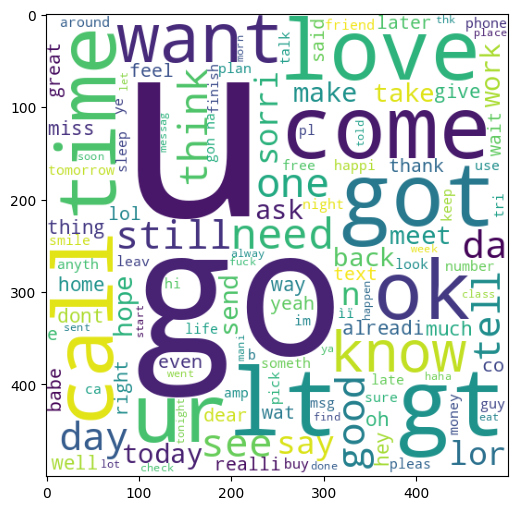

In [45]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

In [46]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)
  
print(len(spam_corpus), len(ham_corpus))

9939 35404


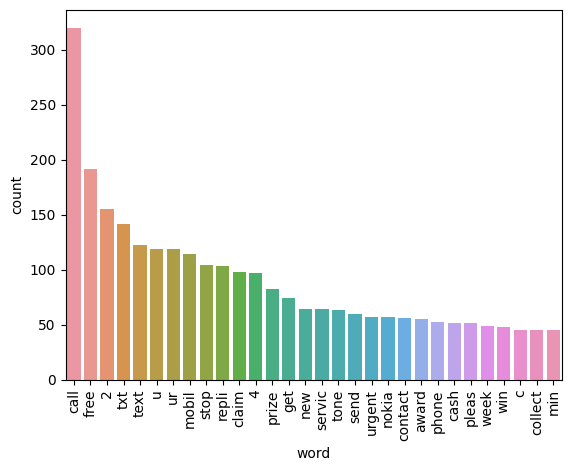

In [47]:
from collections import Counter
word_freq = Counter(spam_corpus).most_common(30)
word_freq_df = pd.DataFrame(word_freq, columns=['word', 'count'])
sns.barplot(data=word_freq_df, x='word', y='count')
plt.xticks(rotation='vertical')
plt.show()

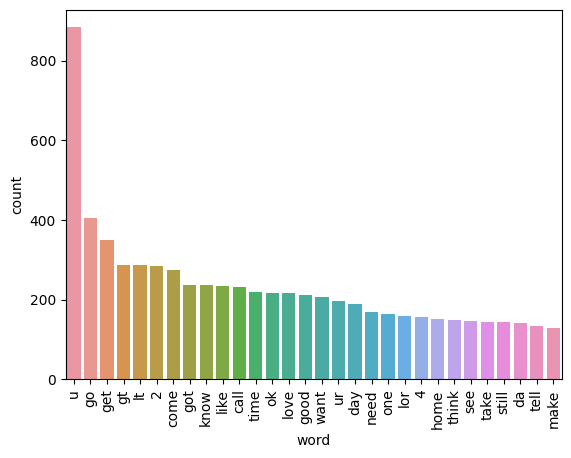

In [48]:
word_freq = Counter(ham_corpus).most_common(30)
word_freq_df = pd.DataFrame(word_freq, columns=['word', 'count'])
sns.barplot(data=word_freq_df, x='word', y='count')
plt.xticks(rotation='vertical')
plt.show()

# Model building

## RNN

In [57]:
X=df['transformed_text']
y = df['target'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [58]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [59]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

In [61]:
model.fit(sequences_matrix,y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
26/26 [==============================] - 10s 35ms/step - loss: 0.3533 - accuracy: 0.8615 - val_loss: 0.1790 - val_accuracy: 0.9516
Epoch 2/10
26/26 [==============================] - 0s 13ms/step - loss: 0.1375 - accuracy: 0.9646 - val_loss: 0.0699 - val_accuracy: 0.9807
Epoch 3/10
26/26 [==============================] - 0s 12ms/step - loss: 0.0659 - accuracy: 0.9822 - val_loss: 0.0871 - val_accuracy: 0.9782


In [62]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [63]:
accr = model.evaluate(test_sequences_matrix,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

33/33 [==============================] - 0s 7ms/step - loss: 0.1039 - accuracy: 0.9681
Test set
  Loss: 0.104
  Accuracy: 0.968


## BERT

In [65]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [67]:
train_input_ids, train_attention_masks = bert_encode(X,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [68]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):
    
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [69]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [70]:
model = create_model(bert_model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                          

In [72]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    y,
    validation_split=0.2, 
    epochs=3,
    batch_size=10
)

Epoch 1/3
414/414 [==============================] - 153s 230ms/step - loss: 0.4252 - accuracy: 0.8660 - val_loss: 0.3533 - val_accuracy: 0.8868
Epoch 2/3
414/414 [==============================] - 76s 183ms/step - loss: 0.4125 - accuracy: 0.8704 - val_loss: 0.3533 - val_accuracy: 0.8868
Epoch 3/3
414/414 [==============================] - 73s 177ms/step - loss: 0.4139 - accuracy: 0.8704 - val_loss: 0.3551 - val_accuracy: 0.8868


In [80]:
def plot_learning_curves(history, arr):
    """
    Plots the training and validation metrics from a Keras history object.
    history: Keras history object
    metrics: list of lists of strings. Each inner list contains the names of the
             metrics to plot on the same graph.
    """
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

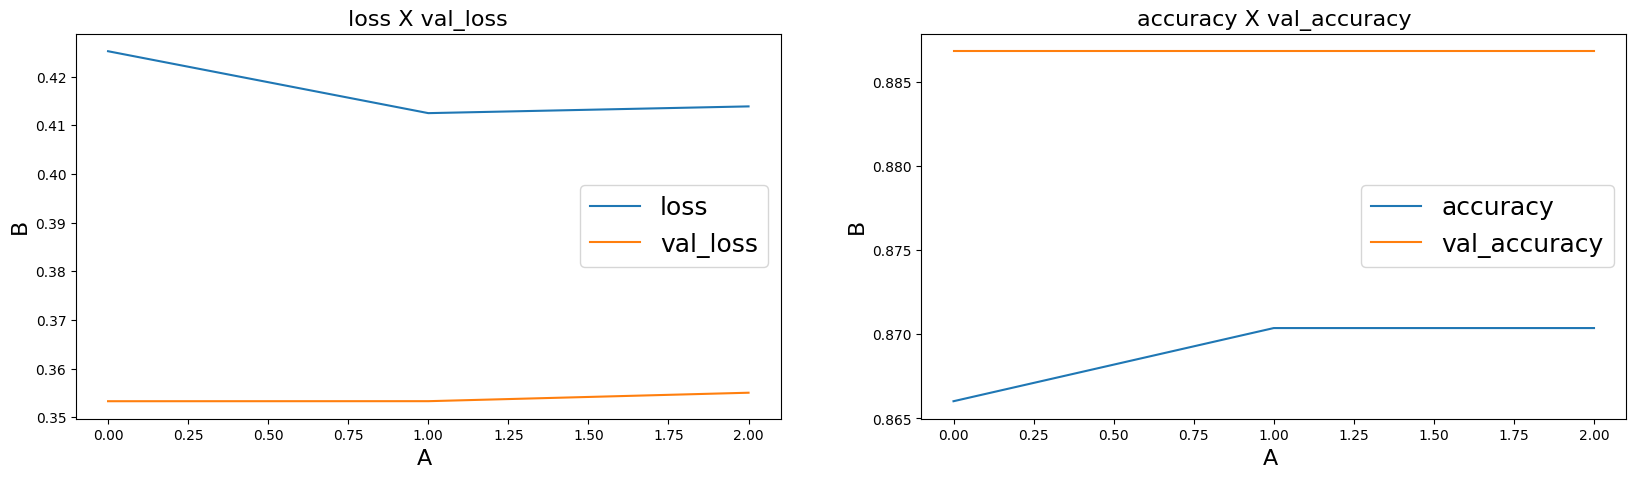

In [81]:
plot_learning_curves(history, [['loss', 'val_loss'], ['accuracy', 'val_accuracy']])

## ML ALGOS

In [23]:
tfidf = TfidfVectorizer(max_features=3000)

In [24]:
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
model_params = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [10]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'logisticregression__C': [1, 5]
        }
    },
    'catboost': {
        'model': CatBoostClassifier(verbose=False),
        'params': {
            'catboostclassifier__iterations': [20],
            'catboostclassifier__learning_rate': [0.01],
            'catboostclassifier__depth': [4]
        }
    },
    'xgboost': {
        'model': XGBClassifier(),
        'params': {
            'xgbclassifier__n_estimators': [50],
            'xgbclassifier__max_depth': [4],
            'xgbclassifier__learning_rate': [0.01],
            'xgbclassifier__booster': ['gbtree']
        }
    },
    'gaussian_nb': {
        'model': GaussianNB(),
        'params': {}
    },
    'multinomial_nb': {
        'model': MultinomialNB(),
        'params': {}
    },
    'bernoulli_nb': {
        'model': BernoulliNB(),
        'params': {}
    },

    'stacking_model': {
        'model': StackingClassifier(
            estimators=[
                ('svc', SVC(kernel='linear', C=1, probability=True)),
                ('rf', RandomForestClassifier(n_estimators=10, random_state=42))
            ],
            final_estimator=LogisticRegression()
        ),
        'params': {
            'stackingclassifier__svc__kernel': ['rbf', 'linear'],
            'stackingclassifier__svc__C': [1, 10],
            'stackingclassifier__rf__n_estimators': [1, 5],
            'stackingclassifier__final_estimator__C': [1, 5]
        }
    }
}

# Run a grid search to find the best hyperparameters for each model
best_scores = []
best_estimators = {}
kfold = KFold(n_splits=5, shuffle=True, random_state=42)


for algo, mp in model_params.items():
    pipe = make_pipeline(MinMaxScaler(), mp['model'])
    clf =  RandomizedSearchCV(pipe, mp['params'], cv=kfold, return_train_score=False)
    clf.fit(X_train, y_train)
    best_scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(best_scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,random_forest,0.965417,{'randomforestclassifier__n_estimators': 10}
1,logistic_regression,0.975816,{'logisticregression__C': 5}
2,catboost,0.918259,"{'catboostclassifier__learning_rate': 0.01, 'c..."
3,xgboost,0.931560,"{'xgbclassifier__n_estimators': 50, 'xgbclassi..."
4,gaussian_nb,0.863362,{}
5,multinomial_nb,0.976300,{}
6,bernoulli_nb,0.975816,{}
7,stacking_model,0.974849,"{'stackingclassifier__svc__kernel': 'linear', ..."


In [ ]:
for algo, estimator in best_estimators.items():
    print(f"Evaluating {algo}...")
    score = estimator.score(X_test, y_test)
    print(f"Test score: {score}\n")

Evaluating random_forest...
Test score: 0.9642166344294004

Evaluating logistic_regression...
Test score: 0.9806576402321083

Evaluating catboost...
Test score: 0.8974854932301741

Evaluating xgboost...
Test score: 0.9274661508704062

Evaluating gaussian_nb...
Test score: 0.8588007736943907

Evaluating multinomial_nb...
Test score: 0.9758220502901354

Evaluating bernoulli_nb...
Test score: 0.9729206963249516

Evaluating stacking_model...
Test score: 0.9787234042553191

